# Data Project 2021: School performance across Danish municipalities

The aim of the data project is to investigate primary school performance across Danish municipalities based on the grade point average obtained by the students at the final exam. We fetch data for performance of primary schools from the Danish Ministry of Children and Education. Futhermore, we fetch data from Statistics Denmark covering average income levels and shares of hihgly educated inhabitants in the Danish muncipalities. First, we read and clean the data sets in order to merge them into a single DataFrame. Then, we analyze the data and investigate whether there is positive correlation between income and education levels and the performance of primary schools across municipalities.

**The project is organized as follows:**

1. Data project description
2. Reading and cleaning data
3. Merging data
4. Data analysis
5. Conclusion

**Group:** SSTL

**Members:** Louise Otte Arildsen (srb330), Signe Kolind (hmk792), Stine Fürst (qvj635) & Thomas Nielsen (qzw392)

**Imports and set magics:**

In [103]:
import pandas as pd
import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`
import matplotlib.pyplot as plt
from matplotlib_venn import venn2 # install with pip install matplotlib-venn

## Read and clean data

### School performance data

Reading and cleaning the data

We read the school data in Skoletal.xlsx obtained from education statistics conducted by the Danish Ministry of Children and Education. The data set contains key indicators of performance for the primary schools in Denmark at municpality level. We clean the data by removing redundant columns and renaming the columns:

In [125]:
# read the excel file using pandas, therefore creating an dataframe. 
school = pd.read_excel('Skoletal.xlsx', skiprows=2)

# b. drop columns
drop_these = ['Rækkenavne', 'Overgang 15 mdr ungdomsuddannelse fra 9 og 10 kl', 'Signifikant forskel', 'Forskel', 'Kompetencedækning']
school.drop(drop_these, axis=1, inplace=True)

# c. rename columns
school.rename(columns = {'Institution':'school', 'Skoleår':'year', 
                         'Karaktergennemsnit_skoletal':'gpa', 'Socioøkonomisk reference':'socioeconomic', 
                         'Andel med højest trivsel':'well-being', 'Samlet elevfravær':'absence', 
                         'Elevtal':'students', 'Klassekvotient':'class'}, inplace=True)
# d. rename danish names in rows
school['year'] = school['year'].replace({'København':'Copenhagen'}) #renaming København to Copenhagen

The dataset now looks like this:

In [126]:
school.head()

,school,year,gpa,socioeconomic,well-being,absence,students,class
0,Den Classenske Legatskole,2013/2014,8.2,7.8,NaN,NaN,500.0,24.95
1,Den Classenske Legatskole,Copenhagen,8.2,7.8,NaN,NaN,500.0,24.95
2,Den Classenske Legatskole,2014/2015,7.6,7.5,0.906615,0.089829,521.0,24.90
3,Den Classenske Legatskole,Copenhagen,7.6,7.5,0.906615,0.089829,521.0,24.90
4,Den Classenske Legatskole,2015/2016,8.2,8.0,0.956044,0.079799,515.0,24.90


**Seperate municipality and school year in column 'Year':**

In the data set every row is duplicated such that the data is the same in every column except from in column 'Year'. The column 'Year' alternately displays school year and municipality and we want to split this into two seperate columns.

In [127]:
print(f'The number of rows in data set school is = {len(school)}')

#Then we create a new variable 'municipality', which extract all muncipality names from 'year' using iloc
municipality=pd.DataFrame(school['year'].iloc[1::2].values)

#We check that the number of municipality names are equal to half of the row lines. 
print(f'31328 divided by 2 = {len(school)/2}')
print(f'The number of rows in data set municipality is = {len(municipality)}')

#Then we delete every other row (the ones containing municipalities in the column 'year'
res = [True, False] * 15664 # every uneven number in an index will be removed in a dataset
school_new=school[res] # attaching to the dataframe
school_new.reset_index(drop=True, inplace=True) # resets the index, so ID=0,1,2,N instead of ID=0,2,4,6,N
print(f'The number of rows in dataset school_new is = {len(school_new)}')

#We then concatenate school_new with municipalities and arrive at the solution
school_final = pd.concat([school_new, municipality], axis=1) 
school_final.rename(columns = {school_final.columns[8]:'municipality'}, inplace=True)
school_final.tail(10)

The number of rows in data set school is = 31328
31328 divided by 2 = 15664.0
The number of rows in data set municipality is = 15664
The number of rows in dataset school_new is = 15664


,school,year,gpa,socioeconomic,well-being,absence,students,class,municipality
15654,Himmerlands Ungdomsskole,2017/2018,6.20,6.9,NaN,NaN,140.0,NaN,Vesthimmerlands
15655,Himmerlands Ungdomsskole,2018/2019,6.00,6.4,NaN,NaN,147.0,NaN,Vesthimmerlands
15656,Himmerlands Ungdomsskole,2019/2020,6.95,NaN,NaN,NaN,165.0,NaN,Vesthimmerlands
15657,Vestermarkskolen Aars,2013/2014,NaN,NaN,NaN,NaN,60.0,NaN,Vesthimmerlands
15658,Vestermarkskolen Aars,2014/2015,NaN,NaN,NaN,0.076899,58.0,NaN,Vesthimmerlands
15659,Vestermarkskolen Aars,2015/2016,NaN,NaN,1.0,0.094875,49.0,NaN,Vesthimmerlands
15660,Vestermarkskolen Aars,2016/2017,NaN,NaN,1.0,0.089781,50.0,NaN,Vesthimmerlands
15661,Vestermarkskolen Aars,2017/2018,NaN,NaN,NaN,NaN,49.0,NaN,Vesthimmerlands
15662,Vestermarkskolen Aars,2018/2019,NaN,NaN,NaN,0.082224,46.0,NaN,Vesthimmerlands
15663,Vestermarkskolen Aars,2019/2020,NaN,NaN,NaN,0.085611,47.0,NaN,Vesthimmerlands


**We then only want to investigate the year 2018/2019 and rename it to 2019, since that is the 'afgangsår':**

In [128]:
school_final["year"].replace({"2018/2019": "2019", "2019/2020": "2020"}, inplace=True)

def only_keep_oneyear(df):
    """ delete all year except 2018/2019
    Args:
        df (pd.DataFrame): pandas dataframe with the column "year" as a string

    Returns:
        df (pd.DataFrame): pandas dataframe

    """ 
    for val in ['2019']:
        
        I = df.year.str.contains(val)
        df = df.loc[I == True] # keep everything else
    
    return df
school = only_keep_oneyear(school_final)
school.reset_index(drop=True, inplace=True)
display(school.year.unique())
school.head()

array(['2019'], dtype=object)

,school,year,gpa,socioeconomic,well-being,absence,students,class,municipality
0,Den Classenske Legatskole,2019,7.5,7.6,0.900000,0.071541,505.0,24.75,Copenhagen
1,Nyboder Skole,2019,8.0,7.8,0.950495,0.073004,524.0,22.40,Copenhagen
2,Sølvgades Skole,2019,7.4,7.6,0.901961,0.071107,467.0,23.45,Copenhagen
3,Nørrebro Park Skole,2019,5.3,5.5,0.950331,0.069968,741.0,24.40,Copenhagen
4,Blågård Skole,2019,4.2,5.0,0.876923,0.079616,588.0,21.32,Copenhagen


**DataFrame for merging is gpa mean across muncipalities, we already know it is year 2019**

In [129]:
school_merge=school.groupby(['municipality'])['gpa'].mean().reset_index(name='gpa')
school_merge.head()

,municipality,gpa
0,Aabenraa,6.127814
1,Aalborg,7.013712
2,Aarhus,7.140788
3,Albertslund,6.063983
4,Allerød,7.965370


We notice that 'Christiansø' is a part of our dataset. Christiansø is not a danish municipality, hence it is removed from our data.

In [130]:
school_merge=school_merge.groupby(by="municipality").sum()
school_merge = school_merge.drop("Christiansø", axis=0).reset_index()
school_merge.head()

,municipality,gpa
0,Aabenraa,6.127814
1,Aalborg,7.013712
2,Aarhus,7.140788
3,Albertslund,6.063983
4,Allerød,7.965370


# Income data

We use the module pydst to extract data from Danmarks statistik. This package is designed specifically for this website in order to easily obtain all data. The architecture of the package itself is unknown, and if data from other sites is requested, then the package json would be suitable instead with a more manual approach to API scrapping. 

In [131]:
Dst = pydst.Dst(lang='en') # setup data loader with the langauge 'english'
Dst.get_subjects() # Identifies all the sub areas within Danmarks Statistik with an ID attached

,active,desc,hasSubjects,id
0,True,Population and elections,True,02
1,True,"Labour, income and wealth",True,04
2,True,Prices and consumption,True,06
3,True,Living conditions,True,05
4,True,National accounts and government finances,True,14
5,True,Education and knowledge,True,03
6,True,Business sectors,True,11
7,True,Business sector in general,True,07
8,True,Money and credit market,True,16
9,True,External economy,True,13


We are interested in income data. The desc leads us to ID=04, where the sub area of interest is INDKP107

In [132]:
tables = Dst.get_tables(subjects=['04'])
tables[tables.id == 'INDKP101']

,active,firstPeriod,id,latestPeriod,text,unit,updated,variables
194,True,1987,INDKP101,2019,People,-,2020-11-27 08:00:00,"[region, unit, sex, type of income, time]"


We create a function that reveals information of the different variables contained in sub ID INDKP101

In [133]:
indk_vars = Dst.get_variables(table_id='INDKP101')
display(indk_vars)
for id in ['OMRÅDE','ENHED','KOEN','INDKOMSTTYPE','Tid']:
    print(id)
    values = indk_vars.loc[indk_vars.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

,elimination,id,map,text,time,values
0,True,OMRÅDE,denmark_municipality_07,region,False,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,False,ENHED,NaN,unit,False,"[{'id': '101', 'text': 'People with type of in..."
2,True,KOEN,NaN,sex,False,"[{'id': 'MOK', 'text': 'Men and women, total'}..."
3,False,INDKOMSTTYPE,NaN,type of income,False,"[{'id': '100', 'text': '1 Disposable income (2..."
4,False,Tid,NaN,time,True,"[{'id': '1987', 'text': '1987'}, {'id': '1988'..."


OMRÅDE
 id = 000, text = All Denmark
 id = 01, text = Province Byen København
 id = 101, text = Copenhagen
 id = 147, text = Frederiksberg
 id = 155, text = Dragør
 id = 185, text = Tårnby
 id = 02, text = Province Københavns omegn
 id = 165, text = Albertslund
 id = 151, text = Ballerup
 id = 153, text = Brøndby
 id = 157, text = Gentofte
 id = 159, text = Gladsaxe
 id = 161, text = Glostrup
 id = 163, text = Herlev
 id = 167, text = Hvidovre
 id = 169, text = Høje-Taastrup
 id = 183, text = Ishøj
 id = 173, text = Lyngby-Taarbæk
 id = 175, text = Rødovre
 id = 187, text = Vallensbæk
 id = 03, text = Province Nordsjælland
 id = 201, text = Allerød
 id = 240, text = Egedal
 id = 210, text = Fredensborg
 id = 250, text = Frederikssund
 id = 190, text = Furesø
 id = 270, text = Gribskov
 id = 260, text = Halsnæs
 id = 217, text = Helsingør
 id = 219, text = Hillerød
 id = 223, text = Hørsholm
 id = 230, text = Rudersdal
 id = 04, text = Province Bornholm
 id = 400, text = Bornholm
 id = 

Our variables are 'OMRÅDE','ENHED','KOEN','INDKOMSTTYPE','Tid'. They have id's attached, and not all of them are relevant for the project. Below gives descriptions of the id's for every variable:

- OMRÅDE=*, all areas are relevant. 
- ENHED=116, which is the Average income for all people (DKK). 
- KOEN=MOK. Both genders included. 
- INDKOMSTTYPE=105 is Pre-tax Income, total. 
- TID=2019.

In [134]:
variables1 = {'OMRÅDE':['*'],'ENHED':['116'],'KOEN':['MOK'],'INDKOMSTTYPE':['105'], 
             'Tid':['2019']}
inc_api = Dst.get_data(table_id = 'INDKP101', variables=variables1)
inc_api.head()

,OMRÅDE,ENHED,KOEN,INDKOMSTTYPE,TID,INDHOLD
0,All Denmark,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,338122
1,Province Byen København,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,353203
2,Province Københavns omegn,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,388125
3,Province Nordsjælland,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,414861
4,Province Bornholm,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,291198


In [135]:
inc_1=inc_api.drop(['KOEN','INDKOMSTTYPE','ENHED'], axis=1)

inc_1.rename(columns = {'INDHOLD':'avg_income','OMRÅDE':'municipality','TID':'year'}, inplace=True)
print(f'Years in dat: {inc_1.year.unique()}')
print(f'Municipalities in dat = {len(inc_1.municipality.unique())}')
inc_1.head(5)

Years in dat: [2019]
Municipalities in dat = 110


,municipality,year,avg_income
0,All Denmark,2019,338122
1,Province Byen København,2019,353203
2,Province Københavns omegn,2019,388125
3,Province Nordsjælland,2019,414861
4,Province Bornholm,2019,291198


Like the previous case we see that 'All Denmark' is not a municipality. Its therefore removed. 

In [136]:
avg_inc=inc_1.groupby(by="municipality").sum()
avg_inc = avg_inc.drop("All Denmark", axis=0).reset_index()
avg_inc.head()

,municipality,year,avg_income
0,Aabenraa,2019,305855
1,Aalborg,2019,310886
2,Aarhus,2019,327869
3,Albertslund,2019,295184
4,Allerød,2019,437980


## Education Level data

In [137]:
# List all subjects.
Dst.get_subjects()

# List all tables under the subject Education and knowledge which has the id 03\n",
table = Dst.get_tables(subjects=['03'])

#Choose the table \"HFUDD11: Befolkningens højest fuldførte uddannelse (15-69 år) efter bopælsområde, herkomst, højest fuldførte uddannelse, alder og køn\"\n",
table[table.id == 'HFUDD11']

# Get the variables in the dataset HFUDD11\n",
Edd_vars = Dst.get_variables(table_id='HFUDD11')
Edd_vars

# List all the ID of the of variable in the dataset HFUDD11:\n",
Edd_vars = Dst.get_variables(table_id='HFUDD11')
for id in ['BOPOMR','HERKOMST','HFUDD','Tid','ALDER']:
    print(id)
    values = Edd_vars.loc[Edd_vars.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

BOPOMR
 id = 000, text = All Denmark
 id = 084, text = Region Hovedstaden
 id = 101, text = Copenhagen
 id = 147, text = Frederiksberg
 id = 155, text = Dragør
 id = 185, text = Tårnby
 id = 165, text = Albertslund
 id = 151, text = Ballerup
 id = 153, text = Brøndby
 id = 157, text = Gentofte
 id = 159, text = Gladsaxe
 id = 161, text = Glostrup
 id = 163, text = Herlev
 id = 167, text = Hvidovre
 id = 169, text = Høje-Taastrup
 id = 183, text = Ishøj
 id = 173, text = Lyngby-Taarbæk
 id = 175, text = Rødovre
 id = 187, text = Vallensbæk
 id = 201, text = Allerød
 id = 240, text = Egedal
 id = 210, text = Fredensborg
 id = 250, text = Frederikssund
 id = 190, text = Furesø
 id = 270, text = Gribskov
 id = 260, text = Halsnæs
 id = 217, text = Helsingør
 id = 219, text = Hillerød
 id = 223, text = Hørsholm
 id = 230, text = Rudersdal
 id = 400, text = Bornholm
 id = 411, text = Christiansø
 id = 085, text = Region Sjælland
 id = 253, text = Greve
 id = 259, text = Køge
 id = 350, text 

In [138]:
# Using the IDs from the previous table we get the data
variables_2 = {'BOPOMR':['*'],'HERKOMST':['*'],'HFUDD':['H10','H20','H30','H40','H50','H60','H70','H80'],'Tid':['*'],'KØN':['*'],'ALDER':['TOT']}
edu_api = Dst.get_data(table_id = 'HFUDD11', variables=variables_2)
edu_api.head()

,BOPOMR,HERKOMST,HFUDD,TID,KØN,ALDER,INDHOLD
0,Haderslev,Persons of Danish origin,H80 PhD programs,2008,Women,"Age, total",5
1,Haderslev,Persons of Danish origin,H80 PhD programs,2008,Men,"Age, total",15
2,Haderslev,Persons of Danish origin,H80 PhD programs,2008,Total,"Age, total",20
3,Billund,Total,H10 Primary education,2008,Women,"Age, total",3565
4,Billund,Total,H10 Primary education,2008,Men,"Age, total",3489


In [139]:
#Drop colum ALDER and KØN
drop_these = ['ALDER','KØN']
edu_api.drop(drop_these ,axis=1,inplace=True)
edu_api.head(5)

,BOPOMR,HERKOMST,HFUDD,TID,INDHOLD
0,Haderslev,Persons of Danish origin,H80 PhD programs,2008,5
1,Haderslev,Persons of Danish origin,H80 PhD programs,2008,15
2,Haderslev,Persons of Danish origin,H80 PhD programs,2008,20
3,Billund,Total,H10 Primary education,2008,3565
4,Billund,Total,H10 Primary education,2008,3489


In [140]:
#Translate the names of the variable to english
edu_api.rename(columns={'BOPOMR':'municipality','HERKOMST':'origin','TID':'year','HFUDD':'education','INDHOLD':'number of individuals'},inplace=True)
edu_api.head(5)

,municipality,origin,education,year,number of individuals
0,Haderslev,Persons of Danish origin,H80 PhD programs,2008,5
1,Haderslev,Persons of Danish origin,H80 PhD programs,2008,15
2,Haderslev,Persons of Danish origin,H80 PhD programs,2008,20
3,Billund,Total,H10 Primary education,2008,3565
4,Billund,Total,H10 Primary education,2008,3489


In [141]:
# Using the IDs from the previous table we get the data
variables_2 = {'BOPOMR':['*'],'HERKOMST':['TOT'],'HFUDD':['TOT','H70','H80'],'Tid':['2019'],'KØN':['TOT'],'ALDER':['TOT']}
edu_api = Dst.get_data(table_id = 'HFUDD11', variables=variables_2)
edu_api.head(5)

,BOPOMR,HERKOMST,HFUDD,TID,KØN,ALDER,INDHOLD
0,All Denmark,Total,H70 Masters programs,2019,Total,"Age, total",419094
1,All Denmark,Total,H80 PhD programs,2019,Total,"Age, total",37792
2,All Denmark,Total,Total,2019,Total,"Age, total",4040015
3,Region Nordjylland,Total,H70 Masters programs,2019,Total,"Age, total",27756
4,Region Nordjylland,Total,H80 PhD programs,2019,Total,"Age, total",2023


In [142]:
#total
total =  edu_api['HFUDD']=='Total'
print(total.head())
df_total=edu_api[total].groupby(['BOPOMR'])['INDHOLD'].sum().reset_index(name='sumtotal')

#highly
highly =  (edu_api['HFUDD']=='H70 Masters programs') | (edu_api['HFUDD']=='H80 PhD programs')
print(highly.head())
df_highly=edu_api[highly].groupby(['BOPOMR'])['INDHOLD'].sum().reset_index(name='sumhighly')

together = pd.merge(df_total, df_highly, on=['BOPOMR'], how='left')
together['highly_educ']=together['sumhighly']/together['sumtotal']


together.rename(columns = {'BOPOMR':'municipality'}, inplace=True)
together.head(10)

0    False
1    False
2     True
3    False
4    False
Name: HFUDD, dtype: bool
0     True
1     True
2    False
3     True
4     True
Name: HFUDD, dtype: bool


,municipality,sumtotal,sumhighly,highly_educ
0,Aabenraa,39525,1851,0.046831
1,Aalborg,156291,18722,0.119789
2,Aarhus,260373,45203,0.173609
3,Albertslund,18997,1419,0.074696
4,All Denmark,4040015,456886,0.113090
5,Allerød,16613,3417,0.205682
6,Assens,27511,1334,0.048490
7,Ballerup,32207,3471,0.107772
8,Billund,17906,839,0.046856
9,Bornholm,25974,1202,0.046277


## Explore data set

In order to be able to explore the raw data, we here provide an interactive plot to show, respectively, the employment and income level in each municipality

The static plot is:

In [143]:
def plot_empl_inc(school,dataset,municipality): 
    
    dataset == 'School'
    df = school_final
    y = 'employment'

    
    I = df['municipality'] == municipality
    ax = df.loc[I,:].plot(x='year', y=y, style='-o')

The interactive plot is:

## Merge data sets

We now create a data set with **municpalities which are in both of our data sets**. We can illustrate this **merge** as:

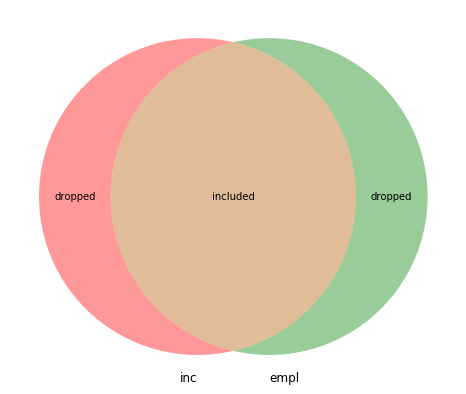

In [144]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('inc', 'empl'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

In [145]:
merged = pd.merge(school_merge, together, how='left',on=['municipality'])
merged = pd.merge(merged, avg_inc, how='left',on=['municipality'])
merged.head()

,municipality,gpa,sumtotal,sumhighly,highly_educ,year,avg_income
0,Aabenraa,6.127814,39525,1851,0.046831,2019,305855
1,Aalborg,7.013712,156291,18722,0.119789,2019,310886
2,Aarhus,7.140788,260373,45203,0.173609,2019,327869
3,Albertslund,6.063983,18997,1419,0.074696,2019,295184
4,Allerød,7.965370,16613,3417,0.205682,2019,437980


In [146]:
print(f'Municipalities in school data = {len(school_merge.municipality.unique())}')
print(f'Municipalities in education data = {len(together.municipality.unique())}')
print(f'Municipalities in income data = {len(avg_inc.municipality.unique())}')

diff_m = [m for m in merged.municipality.unique() if m not in together.municipality.unique()] 
print(f'Municipalities in merged data, but not in education data: {diff_m}')
diff_2 = [m for m in merged.municipality.unique() if m not in avg_inc.municipality.unique()] 
print(f'Municipalities in merged data, but not in income data: {diff_2}')

print(f'Municipalities in merged = {len(merged.municipality.unique())}')

Municipalities in school data = 97
Municipalities in education data = 105
Municipalities in income data = 109
Municipalities in merged data, but not in education data: []
Municipalities in merged data, but not in income data: []
Municipalities in merged = 97


In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
import numpy as np
import datetime

plt.style.use('seaborn-whitegrid')